# Gloo Gateway v2 Fundamentals: From Setup to Monitoring and Operations

This hands-on workshop guides you through the complete lifecycle of deploying and managing Gloo Gateway environment. We will create a local Kubernetes cluster, deploy a sample application, and configure its routing. We will then delve into essential operational skills, including monitoring with Prometheus and Grafana, enabling/viewing access logs, and operationalize your Gloo Gateway environment for scalability, resilience, and security.    
    
Learning objectives:
* Assemble a local Gloo Gateway development environment to accelerate testing and development cycles
* View and monitor observability metrics using Prometheus and Grafana for production-ready monitoring
* Develop foundational skills to operationalize your Gloo Gateway environment for scalability, availability, and security


## Setup & Prerequisites

###  Required Tools
Below are the CLI tools used in this workshop, and their respective installation documentation links

- [Docker](https://docs.docker.com/engine/install/)
- [kind](https://kind.sigs.k8s.io/docs/user/quick-start/#installation)
- [kubectl](https://kubernetes.io/docs/tasks/tools/#kubectl)
- [helm](https://helm.sh/docs/intro/install/)

### Prerequisites

#### 1. Install VSCode Jupyter Notebook Extension

The first few steps cannot be done in Juptyer notebooks directly because you need to install it first.

1. Install the VSCode extension: [VSCode Extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter).
2. Install python. I recommend creating a virtual environment `python -m venv venv`
3. `source venv/bin/activate`
4. `pip install jupyterlab`

Then, click into a `.ipynb` file and set the kernel to use for this notebook, selecting the venv python you just created
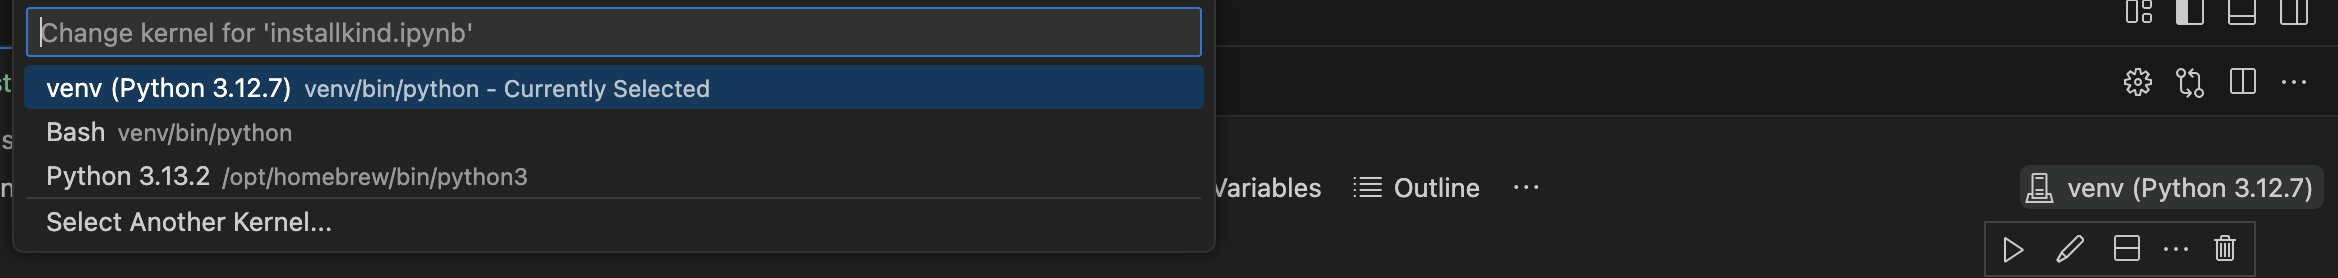

#### 2. Create a kind cluster

Before diving into Gloo Gateway v2, you need a local Kubernetes environment to run the workshop exercises. kind (Kubernetes in Docker) is a lightweight tool that lets you run a Kubernetes cluster on your local machine using Docker containers. This approach is ideal for learning and experimentation

Below we will create a single 3-worker nodes [kind](https://kind.sigs.k8s.io/docs/user/quick-start/#installation) cluster to set up a local Kubernetes environment for this workshop.

In [ ]:
%%bash
CLUSTER_NAME="gg-v2-demo-cluster"
kind create cluster --name ${CLUSTER_NAME} --config data/kind-example-config.yaml

# wait for cluster to be ready
kubectl --context kind-${CLUSTER_NAME} -n kube-system rollout status deploy/coredns
kubectl --context kind-${CLUSTER_NAME}-n local-path-storage rollout status deploy/local-path-provisioner
kubectl --context kind-${CLUSTER_NAME} -n kube-system rollout status ds/kindnet
kubectl --context kind-${CLUSTER_NAME} -n kube-system rollout status ds/kube-proxy

#### 3. Install `cloud-provider-kind`

To ensure your kind cluster behaves like a real-world Kubernetes environment, you need to install the cloud-provider-kind plugin. This plugin simulates cloud provider functionality (like load balancing and persistent storage) within your local kind cluster.

```bash
brew install cloud-provider-kind
```

Alternate installation [documentation](https://github.com/kubernetes-sigs/cloud-provider-kind?tab=readme-ov-file#install)

**Run `cloud-provider-kind` in a terminal window with `sudo`**

```bash
sudo cloud-provider-kind
```

### Deploying Gloo Gateway

#### 1. Install Gloo Gateway v2

In this section, you will transform your kind cluster into a fully functional Gloo Gateway v2 environment. This involves three key steps:

1. **Installing the Kubernetes Gateway API CRDs**  
   The Gateway API is a standardized way to define how traffic enters your Kubernetes cluster. By installing its Custom Resource Definitions (CRDs), you enable the foundation for advanced traffic management.

2. **Deploying the Gloo Gateway CRDs**  
  Gloo Gateway v2 extends the Gateway API with its own custom resources, adding powerful features like advanced routing, security policies, and observability. These CRDs are the building blocks for configuring Gloo Gateway.

3. **Installing Gloo Gateway v2 on your kind cluster**  
   Finally, you will deploy the Gloo Gateway v2 controller and its components, bringing everything together into a fully operational API gateway.

**Why is this important?**  
This setup is the backbone of your Gloo Gateway v2 environment. It allows you to define, manage, and secure your API traffic in a Kubernetes-native way, making it easier to handle complex routing and security requirements.

Below you will install the Kubernetes Gateway API CRDs, deploy the Gloo Gateway v2 CRDs, and install Gloo Gateway v2 on the kind cluster.

In [ ]:
%%bash

kubectl apply --kustomize "https://github.com/kubernetes-sigs/gateway-api/config/crd/experimental?ref=v1.3.0"

helm upgrade -i gloo-gateway-crds oci://us-docker.pkg.dev/solo-public/gloo-gateway/charts/gloo-gateway-crds \
    --create-namespace \
    --namespace gloo-system \
    --version 2.0.0-rc.2

helm upgrade -i gloo-gateway oci://us-docker.pkg.dev/solo-public/gloo-gateway/charts/gloo-gateway \
-n gloo-system \
    --version 2.0.0-rc.2 \
    --set licensing.glooGatewayLicenseKey=$GLOO_GATEWAY_LICENSE_KEY

kubectl rollout status deployment/gloo-gateway -n gloo-system

#### 2. Create a Gateway resource with an HTTP listener

The following command creates a **Gateway** resource in your Kubernetes cluster using the Gateway API. This is a key step in setting up Gloo Gateway as it defines how external traffic can enter your cluster.

**What does this configuration do?**
- **Creates a Gateway named `http`** in the `gloo-system` namespace.
- **Uses the `gloo-gateway-v2` GatewayClass**, which means it will be managed by the Gloo Gateway controller.
- **Listens for HTTP traffic on port 80**. This will not be used for serving traffic.
- **Allows routes from any namespace** in the cluster to be attached to this Gateway, making it flexible for multi-team or multi-application environments.

**Why is this important?**  
This Gateway acts as the main entry point for HTTP traffic into your cluster. By configuring it, you are telling Gloo Gateway how to accept and route incoming requests. This is the foundation for exposing your services to users or other systems outside your Kubernetes cluster.

In [ ]:
%%bash

kubectl apply -f- <<EOF
kind: Gateway
apiVersion: gateway.networking.k8s.io/v1
metadata:
  name: http
  namespace: gloo-system
spec:
  gatewayClassName: gloo-gateway-v2
  allowedListeners:
    namespaces:
      from: All
  listeners:
  - protocol: HTTP
    port: 8080
    name: http
    allowedRoutes:
      namespaces:
        from: All
EOF

kubectl -n gloo-system rollout status deployment/http

### Deploying and exposing a sample application

#### 1. Deploy `httpbin` app

To demonstrate how Gloo Gateway works, we need a simple backend service that can receive and respond to HTTP requests. **httpbin** is a popular open-source application specifically designed for testing and debugging HTTP traffic. It provides a variety of endpoints that return information about the requests they receive, making it ideal for learning and experimentation.

By deploying httpbin:
- You have a safe, predictable backend to test routing, policies, and other Gloo Gateway features.
- You can easily observe how requests are handled and modified as they pass through Gloo Gateway.
- It allows you to try out different configuration scenarios without needing to build your own application.

Below you will deploy the **httpbin** sample application in its own namespace `httpbin`.

In [ ]:
%%bash

kubectl apply -f https://raw.githubusercontent.com/kgateway-dev/kgateway/refs/heads/v2.0.x/examples/httpbin.yaml

kubectl rollout status deployment/httpbin -n httpbin

#### 2. Expose the `httpbin` app

In this section, you will create an **HTTPRoute** resource to expose the httpbin application through Gloo Gateway. This is a crucial step in making your backend service accessible to external traffic.

**What does this configuration do?**

The following YAML defines an HTTPRoute that:

- **Names the route `httpbin`** in the `httpbin` namespace.
- **Attaches the route to the `http` Gateway** you created earlier in the `gloo-system` namespace, ensuring traffic is directed through Gloo Gateway.
- **Specifies the hostname `www.example.com`**, meaning this route will only match requests sent to this hostname.
- **Defines a rule** that forwards traffic to the `httpbin` service on port `8000`, effectively routing external requests to your httpbin application.

**Why is this important?**

By creating this HTTPRoute, you are:

- **Making your httpbin app accessible** to external users or systems.
- **Leveraging Gloo Gateway’s routing capabilities** to direct traffic based on hostnames and paths.
- **Setting the foundation for more advanced configurations**, such as adding [security policies](https://docs.solo.io/gateway/2.0.x/security/) or [resiliency](https://docs.solo.io/gateway/2.0.x/resiliency/).


In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.networking.k8s.io/v1
kind: HTTPRoute
metadata:
  name: httpbin
  namespace: httpbin
spec:
  parentRefs:
    - name: http
      namespace: gloo-system
  hostnames:
    - "www.example.com"
  rules:
    - backendRefs:
        - name: httpbin
          port: 8000
EOF

Verify access to the app:
         
The following command sends an HTTP request to the `/headers` endpoint of the httpbin application. By successfully sending a request and receiving a response from httpbin, you will have confirmed that your Gloo Gateway's setup is operational and ready for further exploration and configuration.

In [ ]:
%%bash

export GLOO_GW_ADDRESS=$(kubectl get svc -n gloo-system http --no-headers | awk '{ print $4 }')
curl -i "http://www.example.com:8080/headers" --resolve "www.example.com:8080:${GLOO_GW_ADDRESS}"

### Observability in action

#### 1. Enable access logging

In this section, you will configure Gloo Gateway to capture detailed access logs for all incoming requests. This is a crucial step for monitoring and troubleshooting your API gateway.

**What does this configuration do?**

You will create an **HTTPListenerPolicy** resource that defines how access logs are captured and formatted. Specifically, this configuration:

- **Writes access logs to the `stdout`** of the gateway proxy container, making them easily accessible for analysis.
- **Uses a custom JSON format** defined in the `jsonFormat` field, allowing you to capture specific details about each request (e.g., request method, path, status code, etc.). For more information, please check out [here](https://docs.solo.io/gateway/2.0.x/security/access-logging/).

**Why is this important?**

- **Visibility:** Access logs provide a clear record of all traffic passing through your gateway, helping you understand usage patterns and diagnose issues.
- **Troubleshooting:** Detailed logs are essential for identifying and resolving problems quickly, especially in production environments.
- **Compliance:** Logging is often a requirement for security and compliance, ensuring you have an audit trail of all API interactions.
    
By enabling access logging, you will have a robust mechanism to monitor and analyze traffic through your Gloo Gateway, setting the foundation for more advanced observability practices.
    
Below you will create an `HTTPListenerPolicy` resource to define your access logging rules. The following confiuguration writes access logs to the `stdout` of the gateway proxy container using a custom string format that is defined in the `jsonFormat` field.

In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.kgateway.dev/v1alpha1
kind: HTTPListenerPolicy
metadata:
  name: access-logs
  namespace: gloo-system
spec:
  targetRefs:
  - group: gateway.networking.k8s.io
    kind: Gateway
    name: http
  accessLog:
  - fileSink:
      path: /dev/stdout
      jsonFormat:
          start_time: "%START_TIME%"
          method: "%REQ(X-ENVOY-ORIGINAL-METHOD?:METHOD)%"
          path: "%REQ(X-ENVOY-ORIGINAL-PATH?:PATH)%"
          protocol: "%PROTOCOL%"
          response_code: "%RESPONSE_CODE%"
          response_flags: "%RESPONSE_FLAGS%"
          bytes_received: "%BYTES_RECEIVED%"
          bytes_sent: "%BYTES_SENT%"
          total_duration: "%DURATION%"
          resp_backend_service_time: "%RESP(X-ENVOY-UPSTREAM-SERVICE-TIME)%"
          req_x_forwarded_for: "%REQ(X-FORWARDED-FOR)%"
          user_agent: "%REQ(USER-AGENT)%"
          request_id: "%REQ(X-REQUEST-ID)%"
          authority: "%REQ(:AUTHORITY)%"
          backendHost: "%UPSTREAM_HOST%"
          backendCluster: "%UPSTREAM_CLUSTER%"
EOF

Send a request to the `httpbin` app to generate access logging data

In [ ]:
%%bash

export GLOO_GW_ADDRESS=$(kubectl get svc -n gloo-system http --no-headers | awk '{ print $4 }')
curl -i "http://www.example.com:8080/headers" --resolve "www.example.com:8080:${GLOO_GW_ADDRESS}"

Get the logs for the gateway pod and verify you see a stdout JSON entry for the request

In [ ]:
%%bash

kubectl -n gloo-system logs deployments/http | grep ^{ | tail -1 | jq --sort-keys

This log entry above provides a comprehensive snapshot of a single HTTP request, capturing details about the client, the request itself, the backend service, and the response. Such detailed logging is invaluable for:
* Monitoring: Tracking traffic patterns and identifying anomalies.
* Troubleshooting: Diagnosing issues by correlating request details with backend behavior.
* Security: Auditing access and identifying potential security threats.
* Performance Analysis: Measuring response times and backend efficiency.
By understanding each field, you can better interpret your logs and use them to maintain and optimize your Gloo Gateway deployment.

#### 2. Monitoring Gloo Gateway proxy with Prometheus

You can see the raw Prometheus metrics that are automatically exposed on the gateway proxy by accessing the Prometheus metrics on your gateway.
    
Below you will port-forward the gateway deployment on port `19000` and access the gateway metrics through the `stats/prometheus` endpoint.

In [ ]:
%%bash

kubectl -n gloo-system port-forward deployment/http 19000:19000>/dev/null 2>&1 &
CURRENT_PROCESS_ID=$!

open http://localhost:19000/stats/prometheus

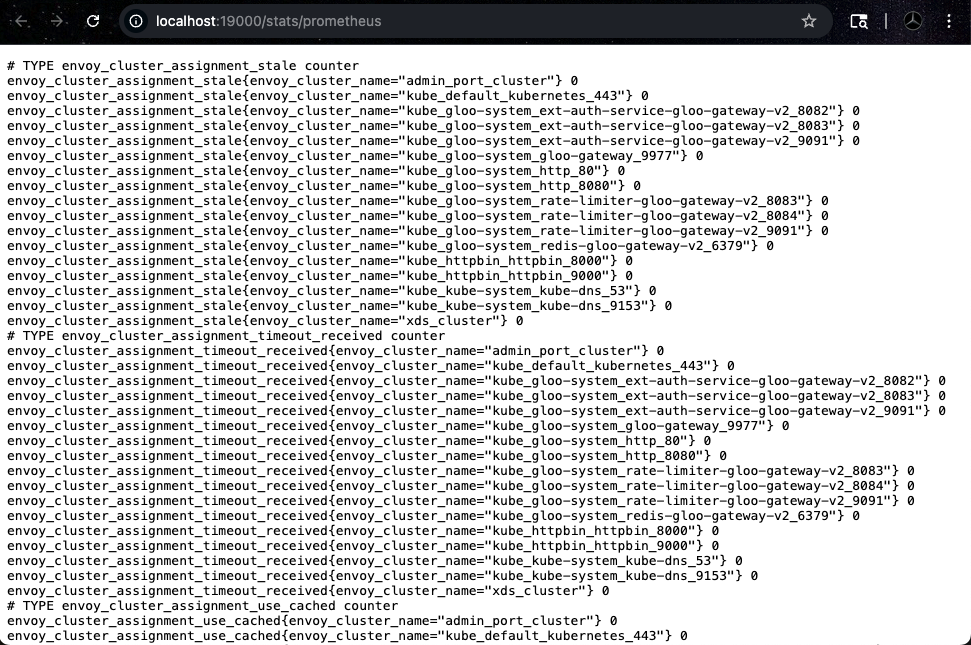

For more details about the collected metrics, see the Envoy statistics reference [docs](https://www.envoyproxy.io/docs/envoy/latest/operations/stats_overview).

Kill the port-foward process

In [ ]:
%%bash

PROCESS_ID=$(ps -ef | grep "kubectl -n gloo-system port-forward deployment/http 19000:19000" | grep -v grep | awk '{print $2}')

if [ -n "$PROCESS_ID" ]; then
  echo "Process found with ID: $PROCESS_ID. Killing it..."
  kill "$PROCESS_ID"
else
  echo "Process not found."
fi

#### 3. Visualizing with Grafana

In this section, you will deploy **Grafana** along with the **kube-prometheus-stack**, which includes Prometheus and other essential monitoring components. This comprehensive monitoring stack will provide you with powerful visualization capabilities for your Gloo Gateway deployment.

Below, you will install Grafana and the Kube-Prometheus-Stack. The stack is a pre-packaged collection of Kubernetes manifests, Grafana dashboards, and Prometheus rules that provides a complete, end-to-end, Kubernetes-native monitoring and alerting solution for your cluster with minimal setup.

In [ ]:
%%bash

helm repo add prometheus-community https://prometheus-community.github.io/helm-charts
helm repo update

helm upgrade --install grafana-prometheus \
  prometheus-community/kube-prometheus-stack \
  --version 76.4.1 \
  --namespace monitoring \
  --create-namespace \
  --values - <<EOF
alertmanager:
  enabled: false
grafana:
  service:
    type: LoadBalancer
    port: 3000
nodeExporter:
  enabled: false
prometheus:
  service:
    type: LoadBalancer
  prometheusSpec:
    ruleSelectorNilUsesHelmValues: false
    serviceMonitorSelectorNilUsesHelmValues: false
    podMonitorSelectorNilUsesHelmValues: false
EOF

kubectl rollout status deployment/grafana-prometheus-kube-pr-operator -n monitoring
kubectl rollout status deployment/grafana-prometheus -n monitoring
kubectl rollout status deployment/grafana-prometheus-kube-state-metrics -n monitoring


Create a `PodMonitor` resource to scrape metrics from the Gloo Gateway Proxy Pod.

The envoy metrics are by default exposed on the port named `http-monitoring`, port number: `9091`

In [ ]:
%%bash

kubectl get pods -l kgateway=kube-gateway -n gloo-system

echo "-------------------------------------------------------------------------------------"

kubectl apply -f- <<EOF
apiVersion: monitoring.coreos.com/v1
kind: PodMonitor
metadata:
  name: gloo-gateway-proxy-monitor
  namespace: gloo-system
spec:
  podMetricsEndpoints:
  - interval: 30s
    port: http-monitoring
    scheme: http
  selector:
    matchLabels:
      kgateway: kube-gateway
EOF

In this section, we will import a pre-built Grafana dashboard specifically designed for monitoring Gloo Gateway. This dashboard provides comprehensive visualizations of the gateway's performance, health, and traffic patterns.

We will import the **official dashboard** from [Gloo Gateway docs](https://docs.solo.io/gateway/latest/observability/grafana.json), which includes:

- **Cluster Traffic & Connections**: Overview of all traffic flowing through your gateways
- **HTTP Request Metrics**: Request rates, response codes, and performance indicators
- **Upstream Service Monitoring**: Health and performance of backend services
- **Connection Statistics**: Active connections and connection management
- **Latency Analysis**: P50, P90, P95, and P99 latency percentiles
- **Error Rate Tracking**: Monitoring of failed requests and error patterns

**Key Dashboard Panels Include:**

1. **Total clusters added/modified**: Tracks the number of backend services discovered and configured
2. **HTTP request rate by Gateways**: Shows request throughput for each gateway
3. **Active clusters**: Displays currently active backend service connections
4. **Upstream request rate**: Monitors traffic to backend services
5. **Total active connections by Gateways**: Shows connection pool utilization
6. **Envoy upstream request latency**: Tracks response times with percentile breakdowns

In [ ]:
%%bash

wget -O ./data/envoy.json https://docs.solo.io/gateway/latest/observability/grafana.json

kubectl -n monitoring create cm envoy-dashboard --from-file=./data/envoy.json

kubectl label -n monitoring cm envoy-dashboard grafana_dashboard=1

Visualize metrics in Grafana    

In this section, you will explore the Grafana dashboard you just imported and generate some traffic to see real-time metrics in action. This hands-on experience will help you understand how Gloo Gateway performs under load and how to interpret the monitoring data.


In [ ]:
%%bash

export GLOO_GW_ADDRESS=$(kubectl get svc -n gloo-system http --no-headers | awk '{ print $4 }')

for i in {1..50};do echo; echo "--- Attempt ${i} ---"; curl -i "http://www.example.com:8080/headers" --resolve "www.example.com:8080:${GLOO_GW_ADDRESS}" > /dev/null; done

Now it's time to explore your monitoring setup! You'll access the Grafana web interface to view the Gloo Gateway dashboard and see your metrics in action.

Open and log into Grafana by using username `admin` and password `prom-operator`

In [ ]:
%%bash

open http://$(kubectl -n monitoring get svc grafana-prometheus --no-headers | awk '{ print $4 }'):3000/dashboards

Go to Dashboards > Envoy to open the dashboard
    
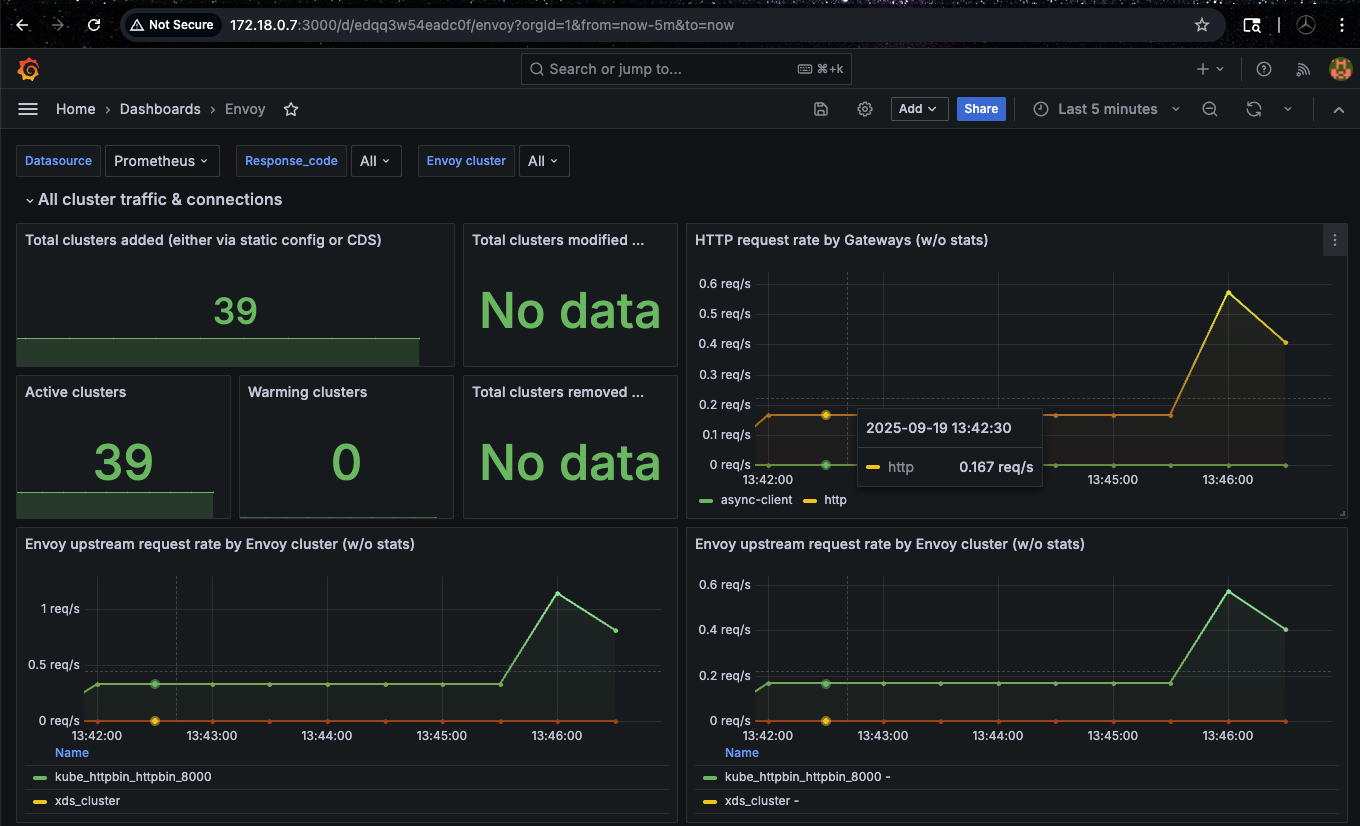

### Operationalizing Gloo Gateway for scalability and resilience

#### 1. Setting timeout on routes

Modify the HTTPRoute created earlier with `timeouts`

In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.networking.k8s.io/v1
kind: HTTPRoute
metadata:
  name: httpbin
  namespace: httpbin
  labels:
    example: httpbin-route
spec:
  parentRefs:
    - name: http
      namespace: gloo-system
  hostnames:
    - "www.example.com"
  rules:
    - backendRefs:
        - name: httpbin
          port: 8000
      timeouts:
        request: "5s"
EOF

Send in a request with a delayed response of 10 seconds. You will receive an 504 Gateway Timeout and `upstream request timeout` error message.

In [ ]:
%%bash

export GLOO_GW_ADDRESS=$(kubectl get svc -n gloo-system http --no-headers | awk '{ print $4 }')
curl -i "http://www.example.com:8080/delay/10" --resolve "www.example.com:8080:${GLOO_GW_ADDRESS}"

Send in another request with a delayed response of 3 seconds. You will receive an 200 OK successful response in 3 seconds.

In [ ]:
%%bash

export GLOO_GW_ADDRESS=$(kubectl get svc -n gloo-system http --no-headers | awk '{ print $4 }')
curl -i "http://www.example.com:8080/delay/3" --resolve "www.example.com:8080:${GLOO_GW_ADDRESS}"

#### 2. Scaling data plane for traffic requirements (horizontal)

In this section, you will create a **GatewayParameters** resource to enable horizontal scaling of your Gloo Gateway proxy instances. This is a crucial step for ensuring your API gateway can handle increased traffic loads and maintain high availability.

Horizontal scaling involves **adding more instances** of the Gloo Gateway proxy to distribute the incoming traffic load across multiple pods. Instead of making a single proxy more powerful (vertical scaling), you create multiple proxy instances that work together. It provides the following values:

- **High Availability**: If one proxy instance fails, traffic automatically routes to the remaining healthy instances, ensuring your API gateway remains operational
- **Load Distribution**: Multiple proxy instances share the incoming traffic, preventing any single instance from becoming overwhelmed
- **Better Performance**: With more instances handling requests, response times improve and the system can handle higher throughput
- **Fault Tolerance**: The system becomes more resilient to individual pod failures, network issues, or resource constraints
- **Scalability**: You can easily scale up or down based on traffic patterns, adding instances during peak loads and removing them during quiet periods

By configuring horizontal scaling, you will have:

- **A more robust API gateway** that can handle varying traffic loads
- **Improved reliability** through redundancy and fault tolerance
- **Better resource utilization** across your Kubernetes cluster
- **The foundation for production-grade deployments**


In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.kgateway.dev/v1alpha1
kind: GatewayParameters
metadata:
  name: custom-gw-params
  namespace: gloo-system
spec:
  kube: 
    deployment:
      replicas: 3
EOF

Create a new Gateway named `custom` with a ListenerSet, and attach the `GatewayParameters` resource

In [ ]:
%%bash

kubectl apply -f- <<EOF
kind: Gateway
apiVersion: gateway.networking.k8s.io/v1
metadata:
  name: custom-http
  namespace: gloo-system
spec:
  gatewayClassName: gloo-gateway-v2
  infrastructure:
    parametersRef:
      name: custom-gw-params
      group: gateway.kgateway.dev
      kind: GatewayParameters      
  allowedListeners:
    namespaces:
      from: All 
  listeners:
  - protocol: HTTP
    port: 80
    name: http
    allowedRoutes:
      namespaces:
        from: All
EOF

kubectl -n gloo-system rollout status deployment/custom-http

Verify three proxy pods were created

In [ ]:
%%bash

kubectl get pods -l app.kubernetes.io/name=custom-http -n gloo-system

#### 3. Scaling data plane for traffic requirements (vertical)

In this section, you will learn how to perform **vertical scaling** of your Gloo Gateway data plane. Unlike horizontal scaling (adding more instances), vertical scaling involves **increasing the resources** allocated to existing proxy instances to handle higher traffic loads. 

This approach focuses on **making individual proxy instances more powerful** by allocating more CPU, memory, and other resources to each pod. This approach increases the capacity of each instance to handle more concurrent requests and process traffic more efficiently.


**When is vertical scaling beneficial?**
- **Resource-Intensive Operations**: When your gateway needs more CPU or memory to process complex routing rules, authentication, or data transformation
- **High Concurrency**: When you need to handle many simultaneous connections on a single instance
- **Memory-Intensive Workloads**: For scenarios requiring large connection pools, extensive caching, or complex request processing
- **Cost Optimization**: In some cases, fewer powerful instances may be more cost-effective than many smaller ones
- **Network Efficiency**: Reducing the number of instances can decrease network overhead and latency

**Key considerations for vertical scaling:**

- **Resource Limits**: Kubernetes pods have maximum resource limits that may constrain vertical scaling
- **Node Capacity**: The underlying Kubernetes nodes must have sufficient resources to accommodate larger pods
- **Cost Implications**: More powerful instances typically cost more, so it's important to balance performance needs with budget constraints
- **Maintenance Impact**: Larger instances may take longer to restart or update during maintenance windows




In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.kgateway.dev/v1alpha1
kind: GatewayParameters
metadata:
  name: custom-gw-params
  namespace: gloo-system
spec:
  kube: 
    envoyContainer:
      resources: 
        requests:
          cpu: "100m" # Requests 0.1 CPU core
          memory: "128Mi" # Requests 128 Megabytes of RAM
        limits:
          cpu: "500m" # Limits to 0.5 CPU core
          memory: "512Mi" # Limits to 512 Megabytes of RAM
EOF

kubectl -n gloo-system rollout status deployment/custom-http

Verify resource settings

In [ ]:
%%bash

kubectl get pods -l app.kubernetes.io/name=custom-http -n gloo-system
echo "-------------------------------------------------------------------------------------"
kubectl get pods -l app.kubernetes.io/name=custom-http \
    -n gloo-system \
    -o jsonpath='{range .items[*]}{"Pod Name: "}{.metadata.name}{"\n"}{range .spec.containers[*]}{"  Container Name: "}{.name}{"\n    Resources: "}{.resources}{"\n"}{end}{"\n"}{end}'

#### 4. Configuring node affinity for Gloo Gateway proxy deployment

In this section, you will learn how to control where your Gloo Gateway proxy pods are scheduled within your Kubernetes cluster by configuring **node affinity**. Node affinity allows you to specify rules that influence which nodes your pods can be deployed on, based on node labels such as geographic zone, hardware type, or other custom attributes.

**What does this configuration do?**

You will use the `podTemplate.affinity.nodeAffinity` field to:

- **Deploy gateway proxies to a specific zone**
- **Ensure that your Gloo Gateway proxies run only on nodes that match your specified criteria**
- **Improve reliability and performance** by distributing traffic across zones or isolating workloads to certain hardware

**Why is node affinity important?**

- **High Availability**: By spreading gateway proxies across multiple zones, you reduce the risk of downtime if a single zone fails.
- **Performance Optimization**: You can place proxies closer to your users or backend services, reducing latency.
- **Resource Management**: Ensures that proxies run on nodes with the right resources or capabilities (e.g., SSDs, GPUs, or specific CPU types).
- **Compliance and Isolation**: Helps meet regulatory or organizational requirements by keeping workloads in specific locations.

**What you'll achieve:**

By configuring node affinity, you will:

- **Gain fine-grained control** over the placement of your Gloo Gateway proxies
- **Enhance the resilience and efficiency** of your API gateway deployment
- **Prepare your environment** for production scenarios where workload placement matters


Below you will deploy three Gloo Gateway proxies in `us-east-1c` zone using the `podTemplate.affinity.nodeAffinity` rules. This could be a use case where the upstreams are co-located in the same zone. Doing so, it will save cloud traffic cost since the Gloo Gateway proxies and the upstreams are in the same cloud zone.

In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.kgateway.dev/v1alpha1
kind: GatewayParameters
metadata:
  name: custom-gw-params
  namespace: gloo-system
spec:
  kube: 
    deployment:
      replicas: 3
    podTemplate:
      affinity:
        nodeAffinity:
          requiredDuringSchedulingIgnoredDuringExecution:
            nodeSelectorTerms:
            - matchExpressions:
              - key: topology.kubernetes.io/zone
                operator: In
                values:
                - us-east-1c
EOF

kubectl -n gloo-system rollout status deployment/custom-http

Verify all three proxy instances are deployed on `cluster1-worker3` in `us-east-1c`

In [ ]:
%%bash

kubectl get nodes -L topology.kubernetes.io/zone
echo -------------------------------------------------------------------------------------
kubectl get pods -l app.kubernetes.io/name=custom-http -n gloo-system -owide

#### 5. Configuring pod anti-affinity for Gloo Gateway proxies for high availability

In this section, you will learn how to use **pod anti-affinity** rules to maximize the availability and resilience of your Gloo Gateway proxy deployment. Pod anti-affinity ensures that multiple instances of your gateway proxies are scheduled on different nodes or zones, reducing the risk of service disruption due to node or zone failures.

**What does this configuration do?**

You will use the `podTemplate.affinity.podAntiAffinity` field to:

- **Distribute gateway proxy pods across three different zones** (or nodes), ensuring that no two proxies run on the same zone or node.
- **Prevent single points of failure** by making sure that a failure in one zone or node does not affect all your gateway proxies.
- **Increase fault tolerance** and maintain service availability even during infrastructure outages.

**Why is pod anti-affinity important?**

- **High Availability**: By spreading pods across zones or nodes, you ensure that your API gateway remains available even if one zone or node goes down.
- **Resilience**: Reduces the impact of hardware, network, or power failures in a single location.
- **Best Practice for Production**: Distributing critical workloads is a standard approach for building robust, production-grade systems.

**What you'll achieve:**

By configuring pod anti-affinity, you will:

- **Enhance the reliability** of your Gloo Gateway deployment
- **Minimize downtime** in the event of node or zone failures
- **Meet high availability requirements** for mission-critical applications

**Example use case:**

If your Kubernetes cluster spans three availability zones, pod anti-affinity ensures that each Gloo Gateway proxy pod is scheduled in a different zone. This way, even if an entire zone becomes unavailable, your API gateway continues to operate in the remaining zones.

Below you will deploy three Gloo Gateway proxies in your Kubernetes clusters and they are spread across all three different zones in the `us-east-1` region using the `podTemplate.affinity.nodeAffinity` rules.

In [ ]:
%%bash

kubectl apply -f- <<EOF
apiVersion: gateway.kgateway.dev/v1alpha1
kind: GatewayParameters
metadata:
  name: custom-gw-params
  namespace: gloo-system
spec:
  kube: 
    deployment:
      replicas: 3
    podTemplate:
      affinity:
        podAntiAffinity:
          preferredDuringSchedulingIgnoredDuringExecution:
          - weight: 100
            podAffinityTerm:
              labelSelector:
                matchExpressions:
                - key: app.kubernetes.io
                  operator: In
                  values:
                  - custom-http # refers to the custom gateway proxy in this workshop
              topologyKey: topology.kubernetes.io/zone
EOF

kubectl -n gloo-system rollout status deployment/custom-http

Verify the three proxy instances are spread acroos three different worker nodes where each of the worker nodes is in its own zone

In [ ]:
%%bash

kubectl get nodes -L topology.kubernetes.io/zone
echo -------------------------------------------------------------------------------------
kubectl get pods -l app.kubernetes.io/name=custom-http -n gloo-system -owide

### Environment teardown

To teardown this environment and delete the cluster, run the following cell

In [ ]:
%%bash

kind delete cluster --name gg-v2-demo-cluster

### Key takeaways

* Learned how to install gateway and create a Gateway resource
* Created an HTTPRoute resource to expose an application
* Learned how to enable access logging, monitor your gateway environment using Prometheus and pre-configured Grafana dashboard
* Acquired knowledge to prepare your Gloo Gateway deployment for production with scalability, resilience, and security.


### Further learning

Gloo Gateway is a feature-rich, fast, and flexible Kubernetes-native ingress controller and next-generation API gateway that is built on top of Envoy proxy and the Kubernetes Gateway API. It provides advanced routing capabilities with security, resiliency, and observability for production use. You can learn more about its features and capabilities [here](https://docs.solo.io/gateway/2.0.x/quickstart/).

In addition, it also includes an [Agentgateway Enterprise](https://docs.solo.io/gateway/2.0.x/ai/about/). It is an enterprise-grade, highly available, highly scalable data plane that provides secure AI connectivity for agents, tools, LLMs, and inference workloads in your cloud-native environment. Designed and engineered to meet the unique requirement of AI and agentic workloads, agentgateway enterprise provides context-aware networking capabilities in Kubernetes. Agentgateway enterprise is based on the [agentgateway](https://agentgateway.dev/) open source project.